# Traditional Portfolio Management

Install required library

In [ ]:
!pip install yfinance
import pandas as pd
from pandas_datareader import data as pdr
import fix_yahoo_finance  # <== that's all it takes :-)
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 6.4 MB 45.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Load stock historical prices

In [ ]:
symbols = ["DELTA", "CPF", "ADVANC", "PTT"]
simple_ret = dict()
for sym in symbols:
  df = yf.download(sym + ".BK", "2016-01-01", "2020-06-30")
  df = df.Close.pct_change(1).dropna()
  simple_ret[sym] = df
simple_ret = pd.DataFrame(simple_ret)
simple_ret 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,DELTA,CPF,ADVANC,PTT
Date,,,,
2016-01-05,0.029032,0.022727,-0.083916,-0.046218
2016-01-06,-0.006270,-0.022222,0.049618,0.004405
2016-01-07,-0.034700,-0.017046,-0.021818,-0.083333
2016-01-08,0.006536,0.011561,0.070632,0.028708
2016-01-11,-0.022727,0.028571,0.003472,-0.018605
...,...,...,...,...
2020-06-23,-0.009346,-0.015625,-0.002625,0.006494
2020-06-24,0.018868,-0.007937,-0.010526,-0.032258
2020-06-25,0.000000,-0.016000,-0.002660,-0.006667


In [ ]:
def findOptPort(data_frames:pd.DataFrame=None, 
                target_ret:float=None, 
                mu_vector:pd.Series=None,
                cov_matrix:pd.DataFrame=None)->list:
  """
    :param data_frames: data_frames of simple returns
    :param target_ret: target return. None for minimum variance portfolio
    :param mu_vector: precomputed mean vector
    :param cov_matrix: precomputed covariance matrix
    :return:
      r: expected annualized return
      vol: expected volatility
      w: weight on each stock in a portfolio

  """
  days_in_year = 365
  
  if data_frames is not None:
    num_data, num_stocks = data_frames.shape  
    mu_vector  = data_frames.mean().values
    cov_matrix = data_frames.cov().values
  num_stocks = mu_vector.shape[0]
  if target_ret is None:
    A = np.zeros((num_stocks + 1, num_stocks + 1))
    A[:num_stocks, :num_stocks] = cov_matrix
    A[:num_stocks, -1] = -1
    A[-1, :num_stocks] = 1
    b = np.zeros(num_stocks + 1)
    b[:num_stocks] = 0
    b[-1] = 1
    x = np.linalg.solve(A, b)     
    w = x[:-1]
    r_min = x[-1]
    vol = np.sqrt(np.dot(np.dot(w.T, cov_matrix), w) * days_in_year)
    r = r_min * days_in_year
    return r, vol, w  
  else:
    A = np.zeros((num_stocks + 2, num_stocks + 2))
    A[:num_stocks, :num_stocks] = cov_matrix
    A[:num_stocks, -1] = -1
    A[-1, :num_stocks] = 1
    A[:num_stocks, -2] = -mu_vector
    A[-2, :num_stocks] = mu_vector
    b = np.zeros(num_stocks + 2)
    b[:num_stocks] = 0
    b[-2] = target_ret/ days_in_year
    b[-1] = 1
    x = np.linalg.solve(A, b)
    w = x[:num_stocks]
    vol = np.sqrt(np.dot(np.dot(w.T, cov_matrix), w) * days_in_year)
    r = target_ret
    return r, vol, w

Building the efficient frontier of the portfolio

In [ ]:
def buildEfficientFrontier(data_frames:pd.DataFrame)->list:
  """
    :param data_frames: data_frames of simple returns
    :return:
       vol_array: volatility of portfolio
       mean_array: expected return of portfolio
  """
  days_in_year = 365
  num_data, num_stocks = data_frames.shape  
  mu_vect  = data_frames.mean().values
  cov_mat = data_frames.cov().values
  r_max = 0.25
  num_shows = int(0.1*num_stocks)
  showed = np.random.permutation(num_stocks)[:num_shows]
  for k in range(num_stocks):
    weights = np.zeros((num_stocks))
    weights[k] = 1
    mean = np.dot(weights, mu_vect) * days_in_year
    if r_max < mean:
      r_max = mean*2.0    
  # find the efficient frontiers
  r_min, vol_min, w_min = findOptPort(mu_vector=mu_vect, cov_matrix=cov_mat)  
  mean_array = np.linspace(r_min, r_max, 1000)
  vol_array = np.zeros((1000,))
  for k in range(1000):
    rk,vk,wk = findOptPort(mu_vector=mu_vect, cov_matrix=cov_mat, 
                           target_ret=mean_array[k])
    vol_array[k] = vk #np.sqrt(np.dot(np.dot(w.T, cov_mat), w) * days_in_year)
 
  return vol_array, mean_array

Plot efficient Portfolio

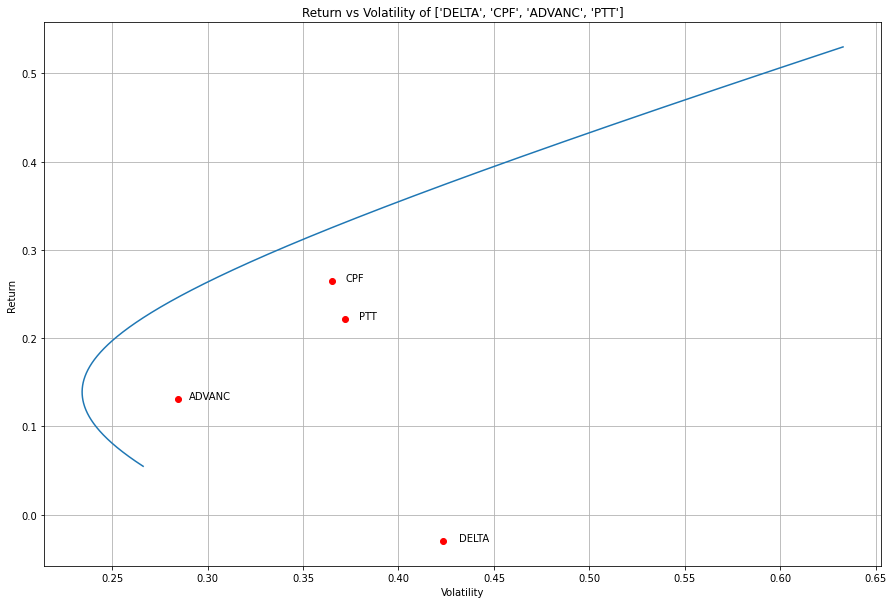

In [ ]:
vol, mu = buildEfficientFrontier(simple_ret)
plt.figure(figsize=(15,10))
plt.plot(vol, mu)
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title(f"Return vs Volatility of {symbols}")
for sym, data in simple_ret.items():
  mu_dat = data.mean()*365
  std_dat = data.std()*np.sqrt(356)
  plt.scatter(std_dat, mu_dat, c='red')
  plt.text(std_dat*1.02, mu_dat, sym)
plt.grid()
plt.show()

In [ ]:
r,vol,w = findOptPort(simple_ret)
print(f"The global minimum variance portfolio (MVP) \
occurs at the volatility of {vol:.2f} with return of {r:.3f}")


The global minimum variance portfolio (MVP) occurs at the volatility of 0.23 with return of 0.055


Find out the MVP portfolio combination

In [ ]:
for k, sym in enumerate(simple_ret.columns):
  print(f"{sym}: {w[k]:0.3f}")

DELTA: 0.179
CPF: 0.176
ADVANC: 0.500
PTT: 0.145


In [ ]:
rs = 0.05
r,vol,w = findOptPort(simple_ret, target_ret=rs)
print(f"The port with target return of {rs*100:0.0f}% has volatility of {vol*100:0.1f}%. ")
for k, sym in enumerate(simple_ret.columns):
  print(f"{sym}: {w[k]:0.3f}")

The port with target return of 5% has volatility of 27.0%. 
DELTA: 0.447
CPF: -0.079
ADVANC: 0.615
PTT: 0.018


Next, we look for the capital market line

In [ ]:
import scipy.optimize as opt 

def findMarketPortfolio(data_frames, rf):
  """
    :param data_frames: data_frames of simple returns
    :param rf: risk-free interest rate
    :return:
      w_opt: Market portfolio 
      vol_opt: volatility of the market portfolio 
      ret_best: return of the market portfolio 
  """
  
  

  days_in_year = 365
  num_data, num_stocks = data_frames.shape  
  mu_vector  = data_frames.mean().values
  cov_matrix = data_frames.cov().values
  num_stocks = mu_vector.shape[0]  
  def sharpe_ratio(target_ret):
    ret, vol, w = findOptPort(mu_vector=mu_vector,
                              cov_matrix=cov_matrix, 
                              target_ret= target_ret)
    return (ret - rf)/vol  
  r_min,_,_ = findOptPort(mu_vector=mu_vector,
                      cov_matrix=cov_matrix)
  best_solution = opt.minimize(lambda x: -sharpe_ratio(x), r_min)
  ret_best = best_solution['x'][0]
  _,vol_opt, w_opt = findOptPort(mu_vector=mu_vector,
                                 cov_matrix=cov_matrix, 
                                 target_ret= ret_best)
  return w_opt , vol_opt, ret_best

In [ ]:
w_opt, vol_opt, ret_opt = findMarketPortfolio(simple_ret, rf=0.02)
for k, sym in enumerate(simple_ret.columns):
  print(f"{sym}: {w_opt[k]:0.3f}")

DELTA: -0.436
CPF: 0.762
ADVANC: 0.237
PTT: 0.437


Let us plot the capital market line

In [ ]:
def plotCapitalMarketLine(data_frames, w_opt, vol_opt, ret_best,rf):
  
  days_in_year = 365
  num_data, num_stocks = data_frames.shape  
  mu_vector  = data_frames.mean().values
  cov_matrix = data_frames.cov().values
  num_stocks = mu_vector.shape[0]
  r_max = -np.inf
  for k in range(num_stocks):
    weights = np.zeros((num_stocks))
    weights[k] = 1
    mean = np.dot(weights, mu_vector) * days_in_year
    if r_max < mean:
      r_max = mean * 1.5
  
  r_min,_,_ = findOptPort(mu_vector=mu_vector,
                          cov_matrix=cov_matrix)
  ret_array = np.linspace(r_min, r_max, 1000)  
  vol_array = np.zeros((1000,))
  for k in range(1000):
    ret, vol, w = findOptPort(mu_vector=mu_vector,
                          cov_matrix=cov_matrix,
                          target_ret= ret_array[k])
    vol_array[k] = vol
  vol_array2 = np.linspace(0, vol_array.max(),1000)
  slope = (ret_best - rf)/vol_opt
  ret_array2 = vol_array2*slope + rf
  plt.figure(figsize=(15,10))
  plt.plot(vol_array, ret_array, vol_array2, ret_array2)
  plt.scatter(vol_opt, ret_best, c="red")
  plt.text(vol_opt*1.01, ret_best, "Market Portfolio")
  plt.xlabel("volatility")
  plt.ylabel("return")
  plt.grid()
  title = "Capital Market Line with "
  for symbol in data_frames.columns:
    title += symbol +" "
  plt.title(title)
  plt.legend(["Efficient Frontier", "Capital Market Line"])
  plt.show()

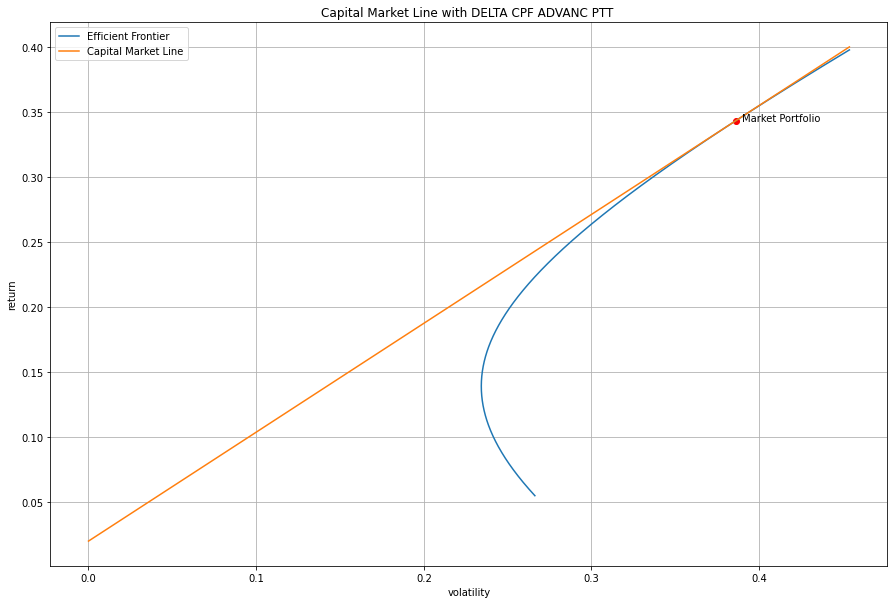

In [ ]:
plotCapitalMarketLine(simple_ret, w_opt, vol_opt, ret_opt, rf=0.02)

Let us invest using the capital market line from 2020-07-01 to 2021-12-13

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Text(0, 0.5, 'Net Worth')

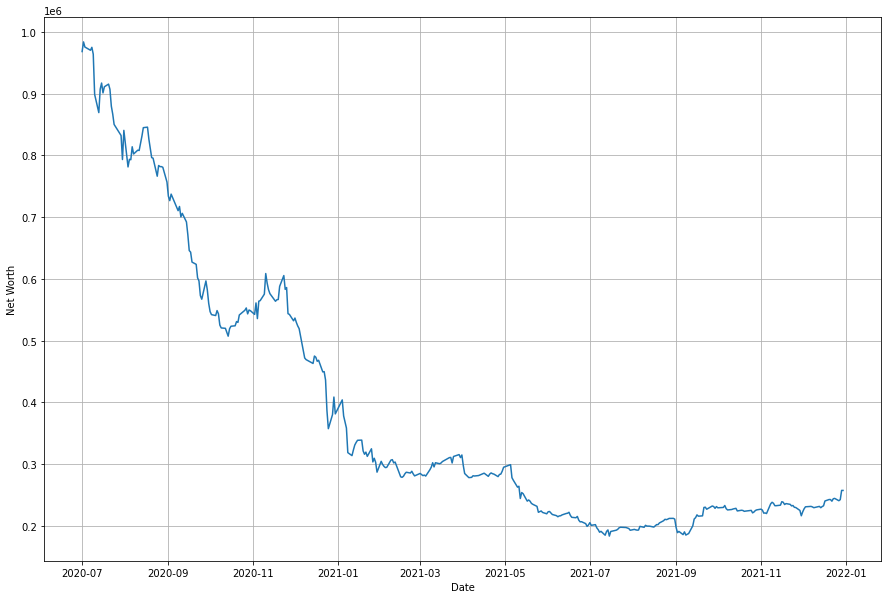

In [ ]:
init_net_worth = 1_000_000
current_net_worth = init_net_worth
stock_prices = dict()
net_worth = dict()
w_port = dict()
for k,sym in enumerate(symbols):
  df2021 = yf.download(sym + ".BK", "2020-07-01", "2021-12-31")
  stock_prices[sym] = df2021
  w_port[sym] =w_opt[k]
  net_worth[sym] = []
net_worth["total"] = []
dates = df2021.index
positions = {sym:[] for sym in symbols}
for date in dates:
  end_of_the_day_net_worth = 0
  for k, sym in enumerate(symbols):
    # use open price to buy stocks 
    num_stocks = (w_port[sym] * current_net_worth) / stock_prices[sym].Open[date]
    positions[sym].append(num_stocks)
    net_worth[sym].append(num_stocks * stock_prices[sym].Close[date])
    end_of_the_day_net_worth +=  num_stocks * stock_prices[sym].Close[date]  
  current_net_worth = end_of_the_day_net_worth
  net_worth["total"].append(end_of_the_day_net_worth)
net_worth = pd.DataFrame(net_worth, index=dates)
plt.figure(figsize=(15,10))
plt.plot(net_worth["total"])
plt.grid()
plt.xlabel("Date")
plt.ylabel("Net Worth")

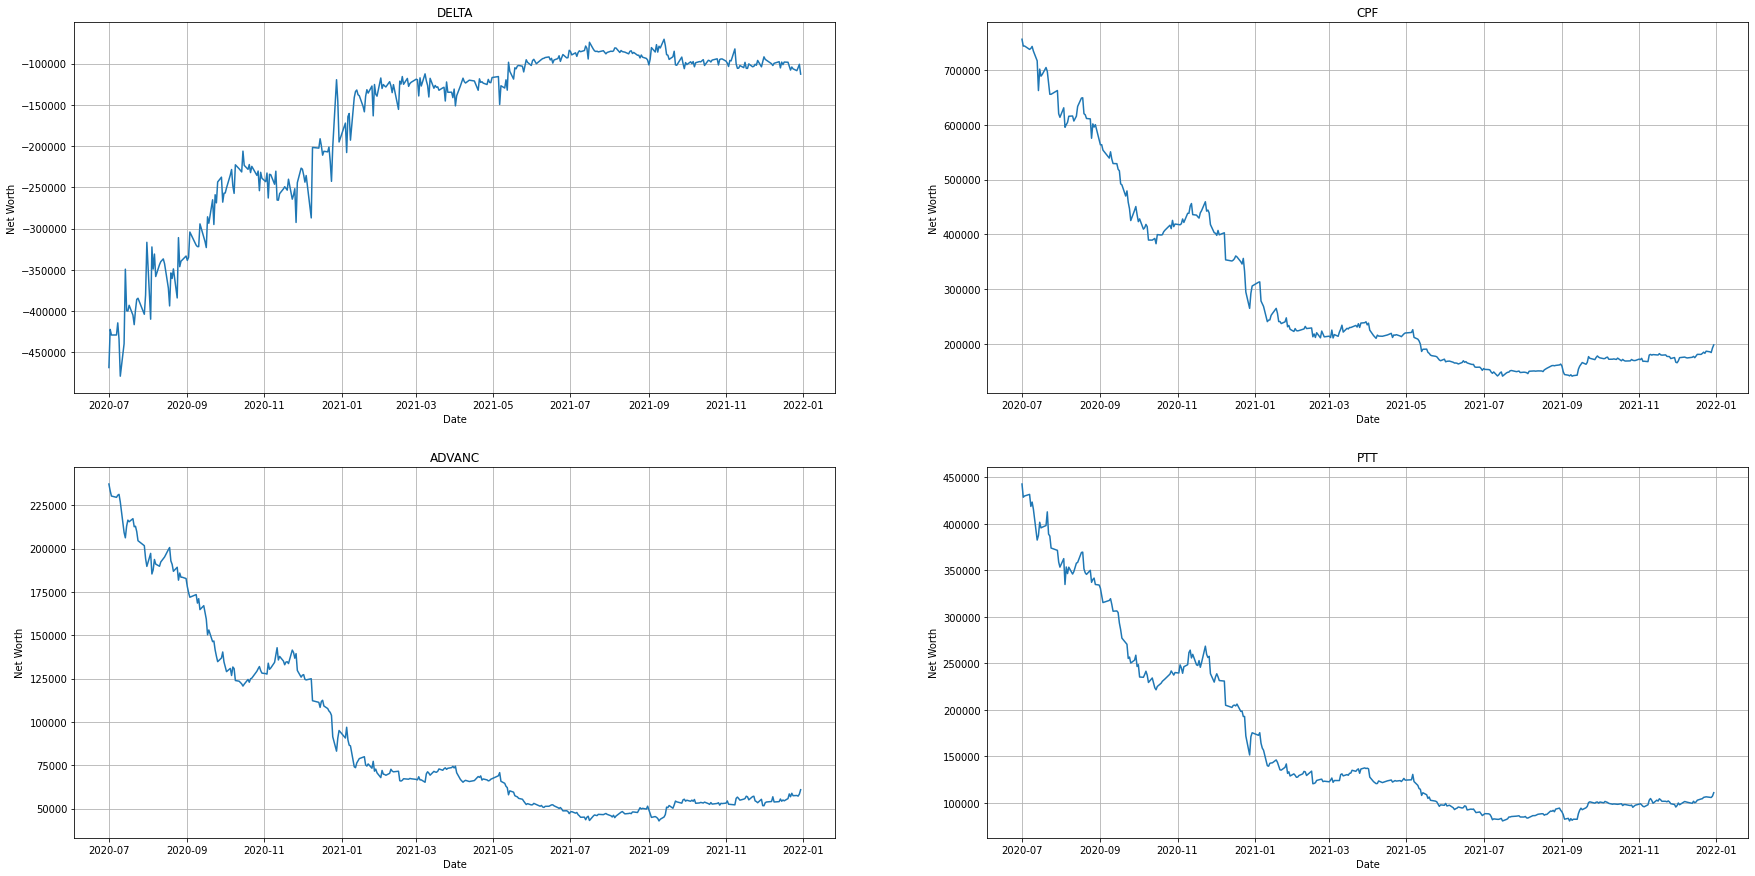

In [ ]:
plt.figure(figsize=(30,15))
for k, sym in enumerate(symbols):
  plt.subplot(2,2, k +1)
  plt.plot(net_worth[sym])
  plt.grid()
  plt.xlabel("Date")
  plt.ylabel("Net Worth")
  plt.title(f"{sym}")

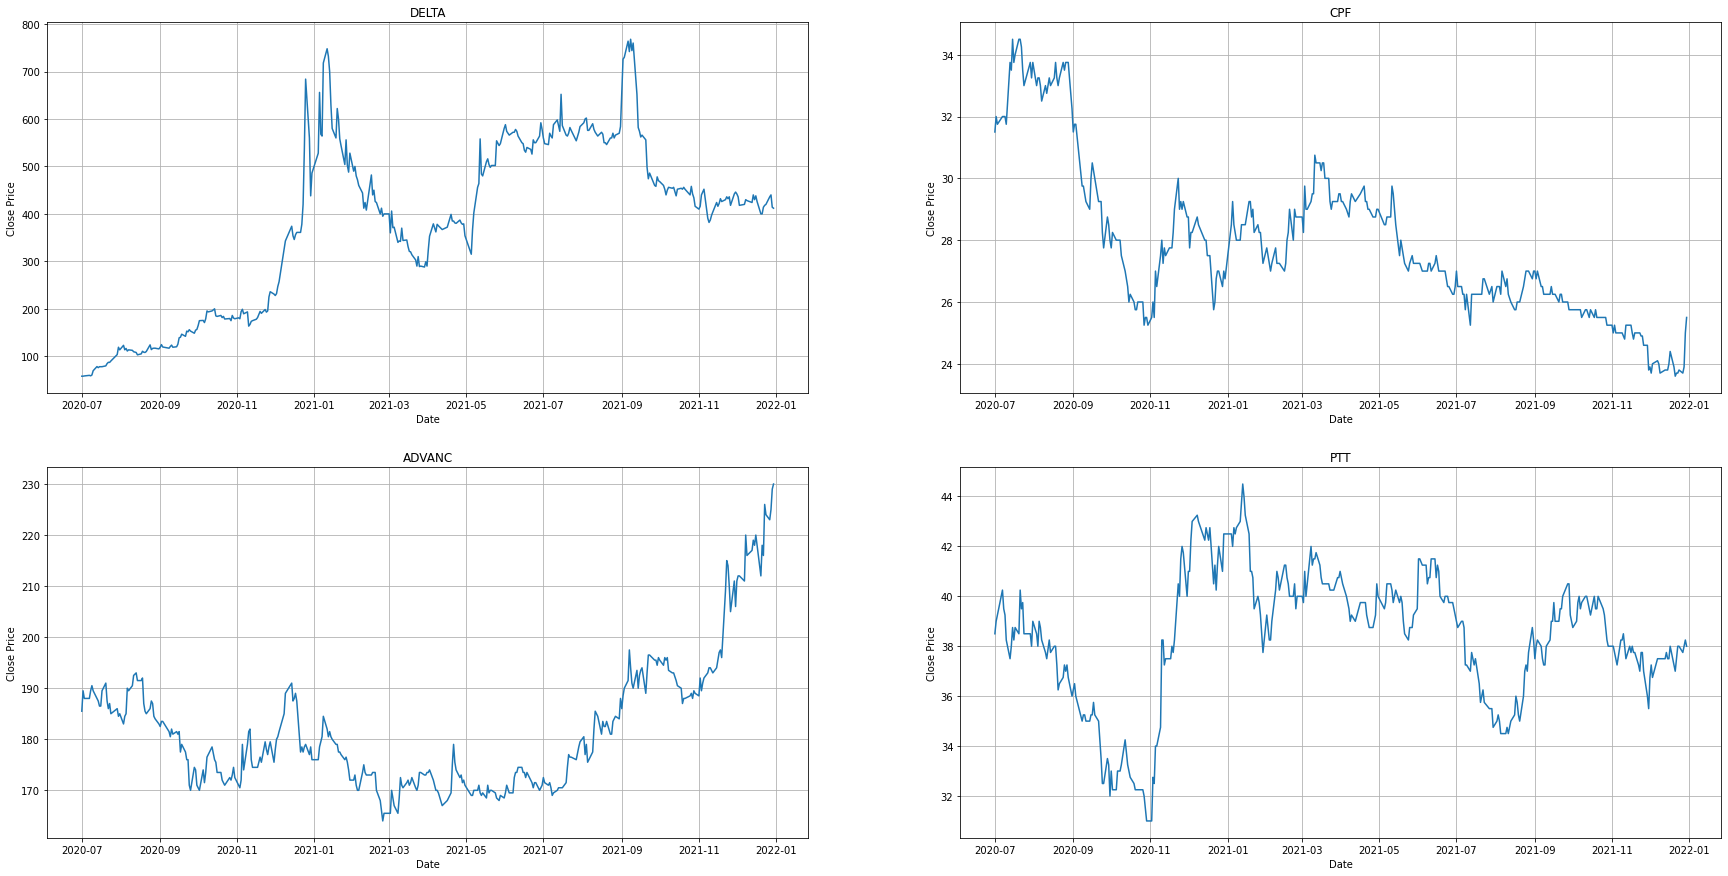

In [ ]:
plt.figure(figsize=(30,15))
for k, sym in enumerate(symbols):
  plt.subplot(2,2, k +1)
  plt.plot(stock_prices[sym].Close)
  plt.grid()
  plt.xlabel("Date")
  plt.ylabel("Close Price")
  plt.title(f"{sym}")

# Work with RL

1. Install tensor trade module

In [ ]:
!pip install git+https://github.com/tensortrade-org/tensortrade.git -U

2. Import libary 

In [ ]:
import tensortrade.env.default as default # de

from tensortrade.feed.core import Stream, DataFeed
from tensortrade.oms.wallets import Portfolio, Wallet
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import Instrument


from tensortrade.agents import DQNAgent
from tensortrade.feed.core.base import NameSpace
from tensortrade.env.default.actions import SimpleOrders
from tensortrade.env.default.rewards import RiskAdjustedReturns, SimpleProfit
from tensortrade.oms.exchanges import Exchange, ExchangeOptions
from tensortrade.oms.orders import TradeType
from tensortrade.env.generic import Stopper
from tensortrade.agents import Agent, ReplayMemory
from tensorflow.keras import layers, models

In [ ]:
def rsi(price: 'pd.Series[pd.Float64Dtype]', period: float) -> 'pd.Series[pd.Float64Dtype]':
    r = price.diff()
    upside = np.minimum(r, 0).abs()
    downside = np.maximum(r, 0).abs()
    rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
    return 100*(1 - (1 + rs) ** -1)

def macd(price: 'pd.Series[pd.Float64Dtype]', fast: float, slow: float, signal: float) -> 'pd.Series[pd.Float64Dtype]':
    fm = price.ewm(span=fast, adjust=False).mean()
    sm = price.ewm(span=slow, adjust=False).mean()
    md = fm - sm
    signal = md - md.ewm(span=signal, adjust=False).mean()
    return signal

In [ ]:
def generate_features(data):
  df = data.copy()
  df.index = pd.DatetimeIndex(df.index)

  features = pd.DataFrame.from_dict({
      'open_pct': data['Open'].pct_change(1).shift(1),        
      'high_pct': data['High'].pct_change(1).shift(1),
      'low_pct': data['Low'].pct_change(1).shift(1),
      'close_pct': data['Close'].pct_change(1).shift(1),
      'vol_pct': data['Volume'].pct_change(1).shift(1),
      'rsi_5': rsi(data['Close'], period=5).shift(1),
      'rsi_10': rsi(data['Close'], period=10).shift(1),
      'rsi_22': rsi(data['Close'], period=22).shift(1),
      'macd_normal': macd(data['Close'], fast=12, slow=26, signal=9).shift(1),
      'macd_short': macd(data['Close'], fast=10, slow=50, signal=5).shift(1),
      })
  data = pd.concat([data, features], axis='columns').fillna(method='pad')
  data = data.dropna()
  return data 


In [ ]:
df_ptt = generate_features(yf.download("PTT.BK", "2015-01-01", "2021-12-31"))
df_cpf = generate_features(yf.download("CPF.BK", "2015-01-01", "2021-12-31") )
df_scb = generate_features(yf.download("SCB.BK", "2015-01-01", "2021-12-31") )
df_adv = generate_features(yf.download("ADVANC.BK", "2015-01-01", "2021-12-31"))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
df_ptt.head()

In [ ]:
PTT =  Instrument("PTT", 2, "ptt")
CPF =  Instrument("CPF", 2, "cpf")
SCB = Instrument("SCB", 2, "scb")
ADVANC = Instrument("ADVANC", 2, "ADVANCE")
THB = Instrument("THB", 2, "thai currency")
data_frames = {"PTT":df_ptt, 
               "CPF":df_cpf, 
               "SCB":df_scb, 
               "ADVANC": df_adv}
symbols = {"PTT":PTT,          
            "CPF":CPF, 
            "SCB":SCB,
            "ADVANC": ADVANC}

In [ ]:
from collections import OrderedDict
from IPython.display import clear_output
import matplotlib.pyplot as plt
class myLogger(default.renderers.ScreenLogger): # perosnalized logger
  def render_env(self,
                 episode: int = None,
                 max_episodes: int = None,
                 step: int = None,
                 max_steps: int = None,
                 price_history: pd.DataFrame = None, # historical prices
                 net_worth: pd.Series = None, # historical port values
                 performance: pd.DataFrame = None,  # historical performances per stock
                 trades: 'OrderedDict' = None):
    
    clear_output()
    plt.figure(figsize=(30,15))   
    print(self._create_log_entry(episode, max_episodes, step, max_steps, date_format=self._date_format))
    print(f"Current Portfolio Net_Worth: {net_worth.iloc[-1]:,.2f}") # print current portfolio size
    r = net_worth.pct_change(1).dropna()
    sharpe = (np.mean(r) + 1e-9)/(np.std(r) + 1e-9)
    print(f"  Sharpe Ration: {sharpe:0.3f}") # sharpe ratio
    current_performance = performance.iloc[-1]
    total_port = net_worth.iloc[-1]
    sum_in_stock = 0
    plt.subplot(4,1,1)
    plt.plot(price_history.date, # date data
             net_worth) # port values
    plt.title("Net Worth") 
    plt.subplot(4,1,2)
    cash = 0
    for key in performance.columns:
      if ("worth" in key) and ("net_worth" not in key):
        plt.plot(price_history.date, performance[key], label=key)  # plot each stock value      
        cash = cash + performance[key]       
    plt.plot(price_history.date, net_worth - cash, label="Cash")  # cash

    plt.legend()
    plt.title("Values")
    total_weights = 0
    plt.subplot(4,1,3)
    for key in performance.columns:
      if ("worth" in key) and ("net_worth" not in key):                
        weight =  performance[key]/ net_worth # weight on each stocks
        total_weights += weight
        plt.plot(price_history.date, weight, label=key)
    plt.plot(price_history.date, 1-total_weights, label="cash")
    plt.legend()
    plt.title("Weights")
    plt.subplot(4,1,4)
    for key in price_history.columns:
      if key != "date":
        plt.plot(price_history.date, 100*price_history[key]/price_history[key].iloc[0] - 100.0, label=key)
    plt.legend()
    plt.title("Gain/Loss (%)")
    plt.pause(0.1)
  
  


class myStopper(Stopper): # perosnalized stopper
  def __init__(self, max_loss=0.01):
    self.max_loss = max_loss
  def stop(self, env: 'TradingEnv') -> bool:
    """Computes if the environment satisfies the defined stopping criteria.
    Parameters
    ----------
    env : `TradingEnv`
        The trading environment.
    Returns
    -------
    bool
        If the environment should stop or continue.
    """
    init_wealth = env.action_scheme.portfolio.initial_net_worth
    curr_wealth = env.action_scheme.portfolio.net_worth
    if curr_wealth < (1 - self.max_loss) * init_wealth:# loss more than given value
      return True
    else:
      return False 
  

In [ ]:
def makeTrainTestEnv(data_frames:dict, # dictionary of features
                     symbols:dict, # symbols of stocks 
                     cutoffDate:str, # cut off date for train and test samples
                     max_loss:float=0.1, # maximum portfolio loss before terminated
                     rf:float=0.001,
                     commission:float=0.001 # trade commission 
                     ):# risk free interst
  train_args = []
  test_args = []
  set_options = ExchangeOptions(commission=commission) # set option on the commission
  for sym, df in data_frames.items(): # add feature into the train and test market
    train_args.append(Stream.source(list(df.Close[:cutoffDate]), dtype="float").rename(f"THB-{sym}"))
    test_args.append(Stream.source(list(df.Close[cutoffDate:]), dtype="float").rename(f"THB-{sym}"))
  train_setmarket = Exchange("SET", service=execute_order,
                             options=set_options)(*train_args)
  test_setmarket = Exchange("SET", service=execute_order,
                             options=set_options)(*test_args)
  train_wallet = [Wallet(train_setmarket, 1_000_000 * THB)] # initialized at 1M THB
  test_wallet = [Wallet(test_setmarket, 1_000_000 * THB)]
  for name, sym in symbols.items():
    new_wallet = Wallet(train_setmarket, 0 * sym) # No position on any stocks
    train_wallet.append(new_wallet)
    new_wallet = Wallet(test_setmarket, 0 * sym)
    test_wallet.append(new_wallet)
  train_portfolio = Portfolio(THB, train_wallet) # Initalized portfolio
  test_portfolio = Portfolio(THB, test_wallet)
  train_data_feed = [] # construct data feeds
  test_data_feed = []
  feature_names= ['open_pct','high_pct','low_pct', 'close_pct','vol_pct', 'rsi_5',
                'rsi_10', 'rsi_22', 'macd_normal', 'macd_short']#, 'macd_long']
  for sym, df in data_frames.items():
    dfktr = []    
    dfkts = []
    for feature in feature_names:
      dfktr.append(Stream.source(list(df[feature][:cutoffDate]), dtype="float").rename(f"{feature}:/THB-{sym}"))
      dfkts.append(Stream.source(list(df[feature][cutoffDate:]), dtype="float").rename(f"{feature}:/THB-{sym}"))
    train_data_feed = train_data_feed + dfktr
    test_data_feed = test_data_feed + dfkts
  train_feed = DataFeed(train_data_feed) # train datafeed
  test_feed = DataFeed(test_data_feed) # test datafee
  train_feed.compile()
  test_feed.compile()
  train_action_scheme = SimpleOrders(criteria=None,  # discrete action
                                     trade_sizes=10, # 10% of th eport
                                     trade_type=TradeType.MARKET) # trade at market price
  test_action_scheme = SimpleOrders(criteria=None,
                                    trade_sizes=10,
                                    trade_type=TradeType.MARKET)
  
  train_render_feed = [Stream.source(list(df[:cutoffDate].index)).rename("date")]
  test_render_feed = [Stream.source(list(df[cutoffDate:].index)).rename("date")]
  # Initialized render with date
  for sym, df in data_frames.items():
    train_render_feed.append(Stream.source(list(df.Close[:cutoffDate]), dtype="float").rename(sym)) # add cloe price
    test_render_feed.append(Stream.source(list(df.Close[cutoffDate:]), dtype="float").rename(sym))
  train_render_feed = DataFeed(train_render_feed) 
  test_render_feed = DataFeed(test_render_feed)

  train_env = default.create(portfolio=train_portfolio, # train environment
                             feed=train_feed,
                             action_scheme=train_action_scheme,
                             reward_scheme=RiskAdjustedReturns(return_algorithm='sortino',
                                                               risk_free_rate=rf,
                                                               window_size=20),
                             renderer_feed=train_render_feed,
                             renderer=myLogger(),
                             random_start_pct=0.99,     
                             window_size=20,
                             stopper=myStopper(max_loss),
                             min_period = 50)
  test_env = default.create(portfolio=test_portfolio, # test environment
                             feed=test_feed,
                             action_scheme=test_action_scheme,
                             reward_scheme="risk-adjusted",
                             renderer_feed=test_render_feed,
                             renderer=myLogger(),                             
                             window_size=20,                             
                             min_period = 50)
  return train_env, test_env

In [ ]:
from collections import namedtuple
DQNTransition = namedtuple('DQNTransition', ['state', 'action', 'reward', 'next_state', 'done'])
import tensorflow as tf 
class myDQNAgent(DQNAgent): # custom Deep-Q class

  def __init__(self,
              train_env: 'TradingEnv',
              test_env: 'TradingEnv',
               policy_network: tf.keras.Model = None):
    self.env = train_env
    self.test_env =  test_env
    self.n_actions = train_env.action_space.n
    self.observation_shape = train_env.observation_space.shape

    self.policy_network = policy_network or self._build_policy_network()

    self.target_network = tf.keras.models.clone_model(self.policy_network)
    self.target_network.trainable = False

    self.env.agent_id = self.id

  def test(self, 
           n_steps: int = 1000,
           use_train=False,
           **kwargs):
    if not use_train:
      batch_size: int = kwargs.get('batch_size', 256)
      state = self.test_env.reset()
      done = False
      steps_done = 0
      total_reward = 0

      while not done: # run to the end
        threshold = 0
        action = np.argmax(self.target_network(np.expand_dims(state, 0)))        
        next_state, reward, done, _ = self.test_env.step(action)        
        state = next_state
        total_reward += reward
        steps_done += 1


      print("TEST RESULT----")
      print("BALANCE")
      print(self.test_env.action_scheme.portfolio.balances)
      print("NET WORTH")
      print(self.test_env.action_scheme.portfolio.net_worth)
      self.test_env.render( )  # renderers final state at episode end if not rendered earlier
    else:
      batch_size: int = kwargs.get('batch_size', 256)
      state = self.env.reset()
      done = False
      steps_done = 0
      total_reward = 0

      while not done:
        threshold = 0
        action = np.argmax(self.target_network(np.expand_dims(state, 0)))        
        next_state, reward, done, _ = self.env.step(action)        
        state = next_state
        total_reward += reward
        steps_done += 1


      print("TEST RESULT----")
      print("BALANCE")
      print(self.env.action_scheme.portfolio.balances)
      print("NET WORTH")
      print(self.env.action_scheme.portfolio.net_worth)
      self.env.render( )  # renderers final state at episode end if not rendered earlier
          
        
  def train(self,
            n_steps: int = 1000,
            n_episodes: int = 10,
            save_every: int = None,
            save_path: str = 'agent/',
            callback: callable = None,
            **kwargs) -> float:
    batch_size: int = kwargs.get('batch_size', 256)
    memory_capacity: int = kwargs.get('memory_capacity', n_steps * 10)
    discount_factor: float = kwargs.get('discount_factor', 0.95)
    learning_rate: float = kwargs.get('learning_rate', 0.01)
    eps_start: float = kwargs.get('eps_start', 0.9)
    eps_end: float = kwargs.get('eps_end', 0.05)
    eps_decay_steps: int = kwargs.get('eps_decay_steps', n_steps)
    update_target_every: int = kwargs.get('update_target_every', 1000)
    render_interval: int = kwargs.get('render_interval', n_steps // 10)  # in steps, None for episode end renderers only
    max_loss: int = kwargs.get('max_loss', 0.1)
    memory = ReplayMemory(memory_capacity, transition_type=DQNTransition) # memory to store historical state, action and reward
    episode = 0
    total_steps_done = 0
    total_reward = 0
    stop_training = False

    if n_steps and not n_episodes:
        n_episodes = np.iinfo(np.int32).max

    print('====      AGENT ID: {}      ===='.format(self.id))

    while episode < n_episodes and not stop_training:
        state = self.env.reset()
        done = False
        steps_done = 0

        while not done:
            threshold = eps_end + (eps_start - eps_end) * np.exp(-total_steps_done / eps_decay_steps)
            action = self.get_action(state, threshold=threshold)
            next_state, reward, done, _ = self.env.step(action)
            if done:
              init_wealth = self.env.action_scheme.portfolio.initial_net_worth
              curr_wealth = self.env.action_scheme.portfolio.net_worth
              pl = (curr_wealth/ init_wealth - 1)
              if pl < -max_loss: # penalty in case we loss more that the maximum
                reward -= 1

            memory.push(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward
            steps_done += 1
            total_steps_done += 1

            if len(memory) < batch_size:
                continue

            self._apply_gradient_descent(memory, batch_size, learning_rate, discount_factor)

            if n_steps and steps_done >= n_steps:
                done = True

            if render_interval is not None and steps_done % render_interval == 0:
                self.env.render(
                    episode=episode,
                    max_episodes=n_episodes,
                    max_steps=n_steps
                )

            if steps_done % update_target_every == 0:
                self.target_network = tf.keras.models.clone_model(self.policy_network)
                self.target_network.trainable = False
                print("PERFORM TESTING")
                self.test()

        is_checkpoint = save_every and episode % save_every == 0

        if save_path and (is_checkpoint or episode == n_episodes - 1):
            self.save(save_path, episode=episode)

        if not render_interval or steps_done < n_steps:
            self.env.render(
                episode=episode,
                max_episodes=n_episodes,
                max_steps=n_steps
            )  # renderers final state at episode end if not rendered earlier

        self.env.save()

        episode += 1

    mean_reward = total_reward / steps_done

    return mean_reward

In [ ]:
max_loss = 0.1 # make the environments
rf = 0.02 / 250
train_env, test_env = makeTrainTestEnv(data_frames, 
                                       symbols, 
                                       cutoffDate="2020-07-01",
                                       max_loss=max_loss,
                                       rf=rf)

In [ ]:
inputs = layers.Input(shape=train_env.observation_space.shape, dtype='float32') # simple CNN network
x1 = layers.Conv1D(filters=64, kernel_size=6, padding="same", activation="tanh")(inputs)
x2 = layers.MaxPool1D(pool_size=2)(x1)
x3 = layers.Conv1D(filters=32, kernel_size=3, padding="same", activation="tanh")(x2)
x4 = layers.MaxPool1D(pool_size=2)(x3)
x4 = layers.Flatten()(x4)
x5 = layers.Dense(train_env.action_space.n, activation="sigmoid")(x4)
x5 = layers.Dense(train_env.action_space.n, activation="softmax")(x5)
policy_model = models.Model(inputs=inputs, outputs=x5)


In [ ]:
agent = myDQNAgent(train_env,  # make trade agent
                   test_env,
                   policy_network=policy_model )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated class DQNAgent. (Builtin agents are being deprecated in favor of external implementations (ie: Ray)) -- Deprecated since version 1.0.4.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
agent.train(n_steps=300, n_episodes=1000, save_path="/content/drive/MyDrive/ComputationalFinance2018/", # train
            render_interval=300,
            max_loss=max_loss)

In [ ]:
agent.test(use_train=True) # Test on Train

In [ ]:
agent.test(use_train=False) # Test on test Data